# RISK_MAP: Anonymous Reproduction Notebook

This notebook runs three project scripts and shows key outputs inline **without printing any file system paths** (for anonymous submission).

Scripts executed:
1. `score_RISK_MAP.py`
2. `monte_carlo_RISK_MAP.py`
3. `cross_layer_pipeline_top3.py`


In [1]:
# Anonymous-friendly PATH discovery (no path printing)
from pathlib import Path
import os

def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(8):  # walk up a few levels
        if (cur / 'scripts').exists() and (cur / 'data').exists():
            return cur
        cur = cur.parent
    # fallback to current working dir
    return start.resolve()

PROJECT_ROOT = find_project_root(Path.cwd())
SCRIPTS_DIR  = PROJECT_ROOT / 'scripts'
DATA_DIR     = PROJECT_ROOT / 'data'
FIG_DIR      = PROJECT_ROOT / 'figures'
OUT_TOPK_DIR = PROJECT_ROOT / 'outputs_topk_mixed'

# Script names (resolved internally)
SCORE_SCRIPT      = 'score_RISK_MAP.py'
MC_SCRIPT         = 'monte_carlo_RISK_MAP.py'
CROSSLAYER_SCRIPT = 'cross_layer_pipeline_top3.py'

# Monte Carlo defaults (feel free to tweak)
MC_RUNS   = 1000
MC_JITTER = 0.25
MC_HIST   = True


In [2]:
# Utilities: sanitized run + display (no absolute paths in output)
import sys, subprocess, re
from IPython.display import display, Markdown, HTML, Image
import pandas as pd

def _candidate_paths(name: str):
    p1 = SCRIPTS_DIR / name
    p2 = PROJECT_ROOT / name
    return [p for p in [p1, p2] if p.exists()]

DRIVE_RE = re.compile(r"[A-Za-z]:\\[^\n\r]+")  # Windows drive-style paths
ROOT_RE  = re.compile(re.escape(str(PROJECT_ROOT)))

def _sanitize(text: str) -> str:
    if not text:
        return text
    t = ROOT_RE.sub("[redacted]", text)
    t = DRIVE_RE.sub("[redacted]", t)
    return t

def run_python_script(script_name: str, args=None, env=None):
    args = list(map(str, args or []))
    for path in _candidate_paths(script_name):
        cmd = [sys.executable, str(path), *args]
        display(Markdown(f"**Running:** `{script_name}`"))
        p = subprocess.run(cmd, cwd=PROJECT_ROOT, capture_output=True, text=True, env={**os.environ, **(env or {})})
        if p.stdout:
            display(Markdown('**stdout**'))
            display(HTML(f"<pre>{_sanitize(p.stdout)}</pre>"))
        if p.stderr:
            display(Markdown('**stderr**'))
            display(HTML(f"<pre style='color:#b00'>{_sanitize(p.stderr)}</pre>"))
        if p.returncode == 0:
            return True
        else:
            display(Markdown(f":warning: `{script_name}` exited with code {p.returncode}."))
            return False
    display(Markdown(f":x: Could not find `{script_name}` in expected locations."))
    return False

def show_csv_anonymous(path: Path, head: int | None = 10, label: str = "Preview"):
    # Show table without revealing full path
    try:
        df = pd.read_csv(path)
        display(Markdown(f"**{label}**"))
        display(df if head is None else df.head(head))
        return True
    except Exception:
        return False

def show_images_anonymous(paths, max_width_px=900, label_prefix: str = "Figure"):
    idx = 1
    any_found = False
    for p in paths:
        p = Path(p)
        if p.exists() and p.suffix.lower() in {'.png', '.jpg', '.jpeg'}:
            any_found = True
            display(Markdown(f"**{label_prefix} {idx}**"))
            display(Image(filename=str(p), width=max_width_px))
            idx += 1
    if not any_found:
        display(Markdown(":grey_exclamation: No PNG/JPG figures found to display."))


## 1) Run RISK_MAP scoring

**Running:** `score_RISK_MAP.py`

**stdout**

**RISK_MAP Per-Layer Scores**

,Robot,Overall,Physical,Sensing and Perception,Data Processing,Middleware,Decision-Making,Application,Social Interface
0,Digit,0.795110,0.063675,0.153886,0.159089,0.226111,0.354131,0.280333,0.094600
1,G1_EDU,0.489290,0.065231,0.062258,0.086002,0.124672,0.062223,0.167277,0.070174
2,Pepper,0.398684,0.015210,0.011200,0.054618,0.044248,0.000000,0.235910,0.087757


**Figure 1**

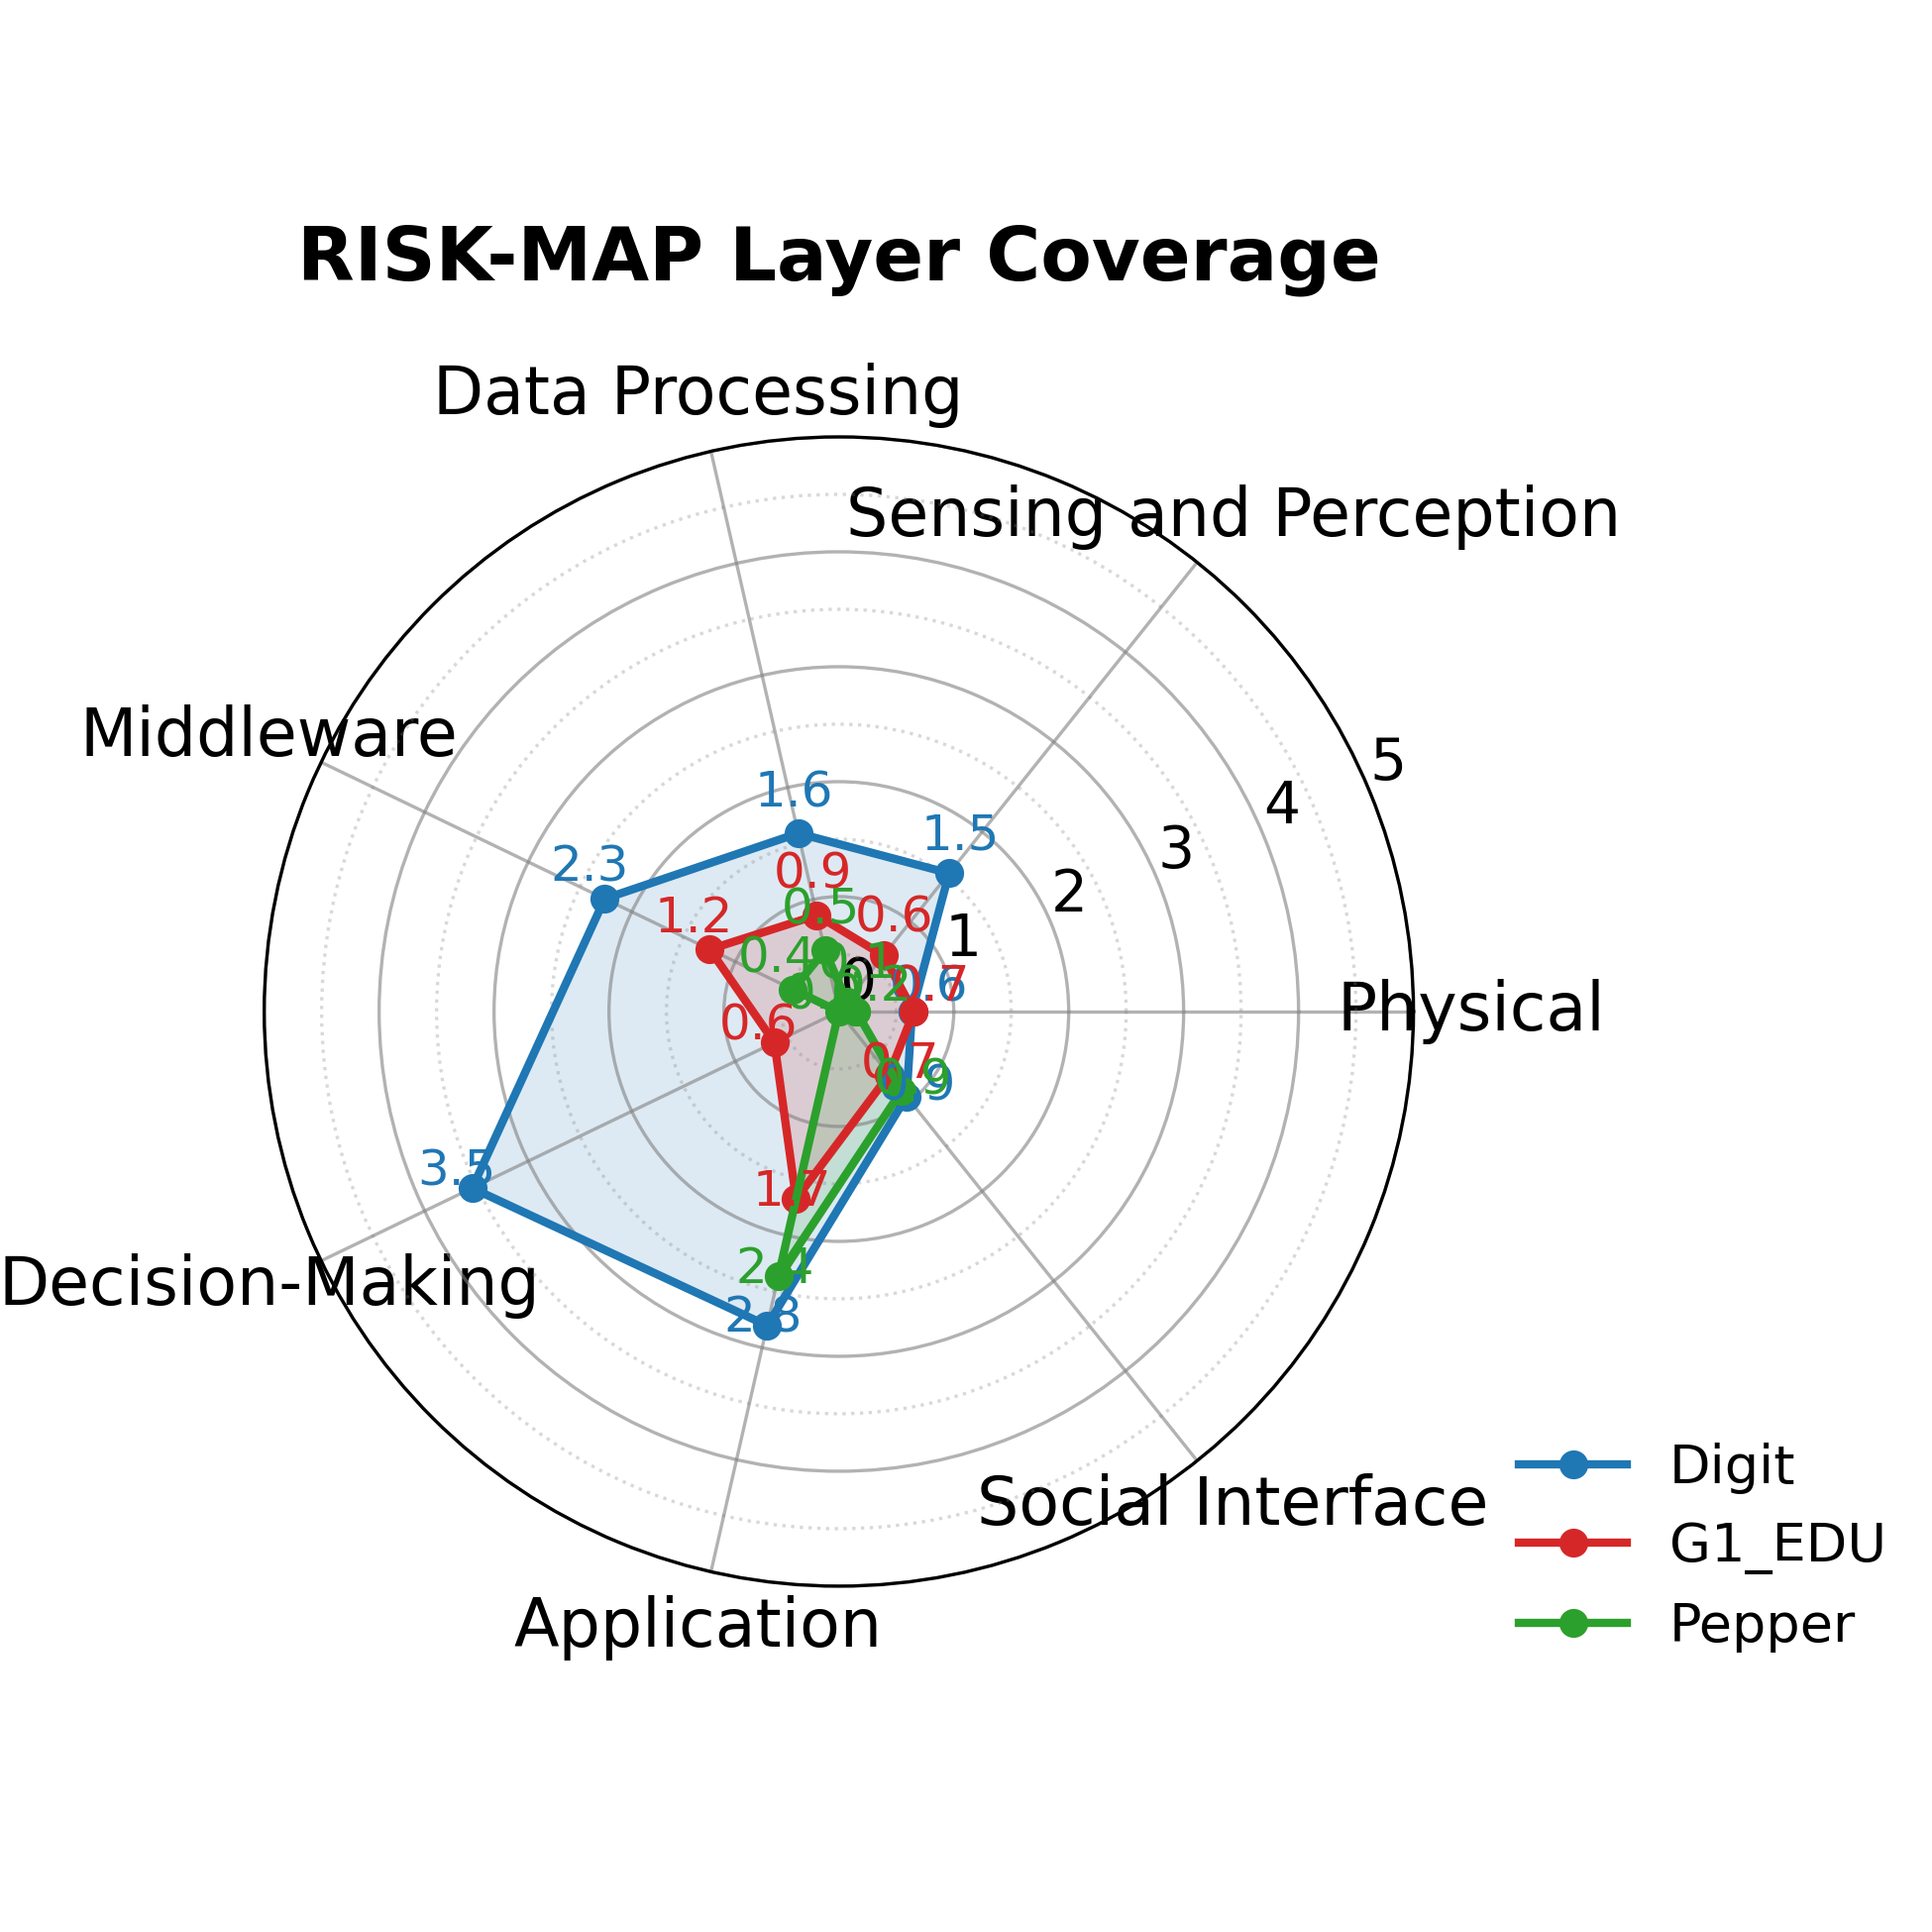

In [3]:
ok = run_python_script('score_RISK_MAP.py')
if ok:
    show_csv_anonymous(DATA_DIR / 'RISK_MAP_Per-Layer_Scores.csv', head=None, label='RISK_MAP Per-Layer Scores')
    show_images_anonymous([FIG_DIR / 'RISK_MAP_combined_radar.png'])

## 2) Run Monte Carlo sensitivity

In [4]:
mc_args = ['--runs', MC_RUNS, '--jitter', MC_JITTER] + (['--hist'] if MC_HIST else [])
ok = run_python_script('monte_carlo_RISK_MAP.py', mc_args)
if ok:
    show_csv_anonymous(DATA_DIR / 'sensitivity' / 'table_sensitivity.csv', head=None, label='Sensitivity Table')

**Running:** `monte_carlo_RISK_MAP.py`

**stdout**

**Sensitivity Table**

,Robot,Mean,Std,Min,Max
0,Digit,0.795524,0.010741,0.758634,0.825753
1,G1_EDU,0.489172,0.016373,0.435725,0.533741
2,Pepper,0.397629,0.017694,0.347296,0.447369


## 3) Run Cross-layer Top-K pipeline

**Running:** `cross_layer_pipeline_top3.py`

**stdout**

**Top-K (mixed-hops)**

,robot,path,rank_metric,CRR,prop_factor,prop_gmean,prop_bottleneck,min_coverage,hops,attack_id
0,Digit,DP>DM>AP,0.168134,0.112963,0.4514,0.671863,0.61,0.30,2,Memory-safety overflow DP-A2
1,Digit,S>DP>DM,0.152309,0.098047,0.4144,0.643739,0.56,0.30,2,Camera/Depth blinding SP-A2
2,Digit,P>S>DP,0.123847,0.064210,0.2688,0.518459,0.48,0.30,2,Firmware reflashing P-A1
3,G1_EDU,S>DP>DM,0.063730,0.041026,0.4144,0.643739,0.56,0.45,2,Camera/Depth blinding SP-A2
4,G1_EDU,DP>DM>AP,0.058200,0.039103,0.4514,0.671863,0.61,0.45,2,Memory-safety overflow DP-A2
5,G1_EDU,P>S>DP,0.048119,0.024948,0.2688,0.518459,0.48,0.45,2,Firmware reflashing P-A1
6,Pepper,S>DP>DM,0.120508,0.077576,0.4144,0.643739,0.56,0.35,2,Camera/Depth blinding SP-A2
7,Pepper,DP>DM>AP,0.117912,0.079221,0.4514,0.671863,0.61,0.35,2,Memory-safety overflow DP-A2
8,Pepper,P>S>DP,0.083407,0.043243,0.2688,0.518459,0.48,0.35,2,Firmware reflashing P-A1


**Top-K Figure 1**

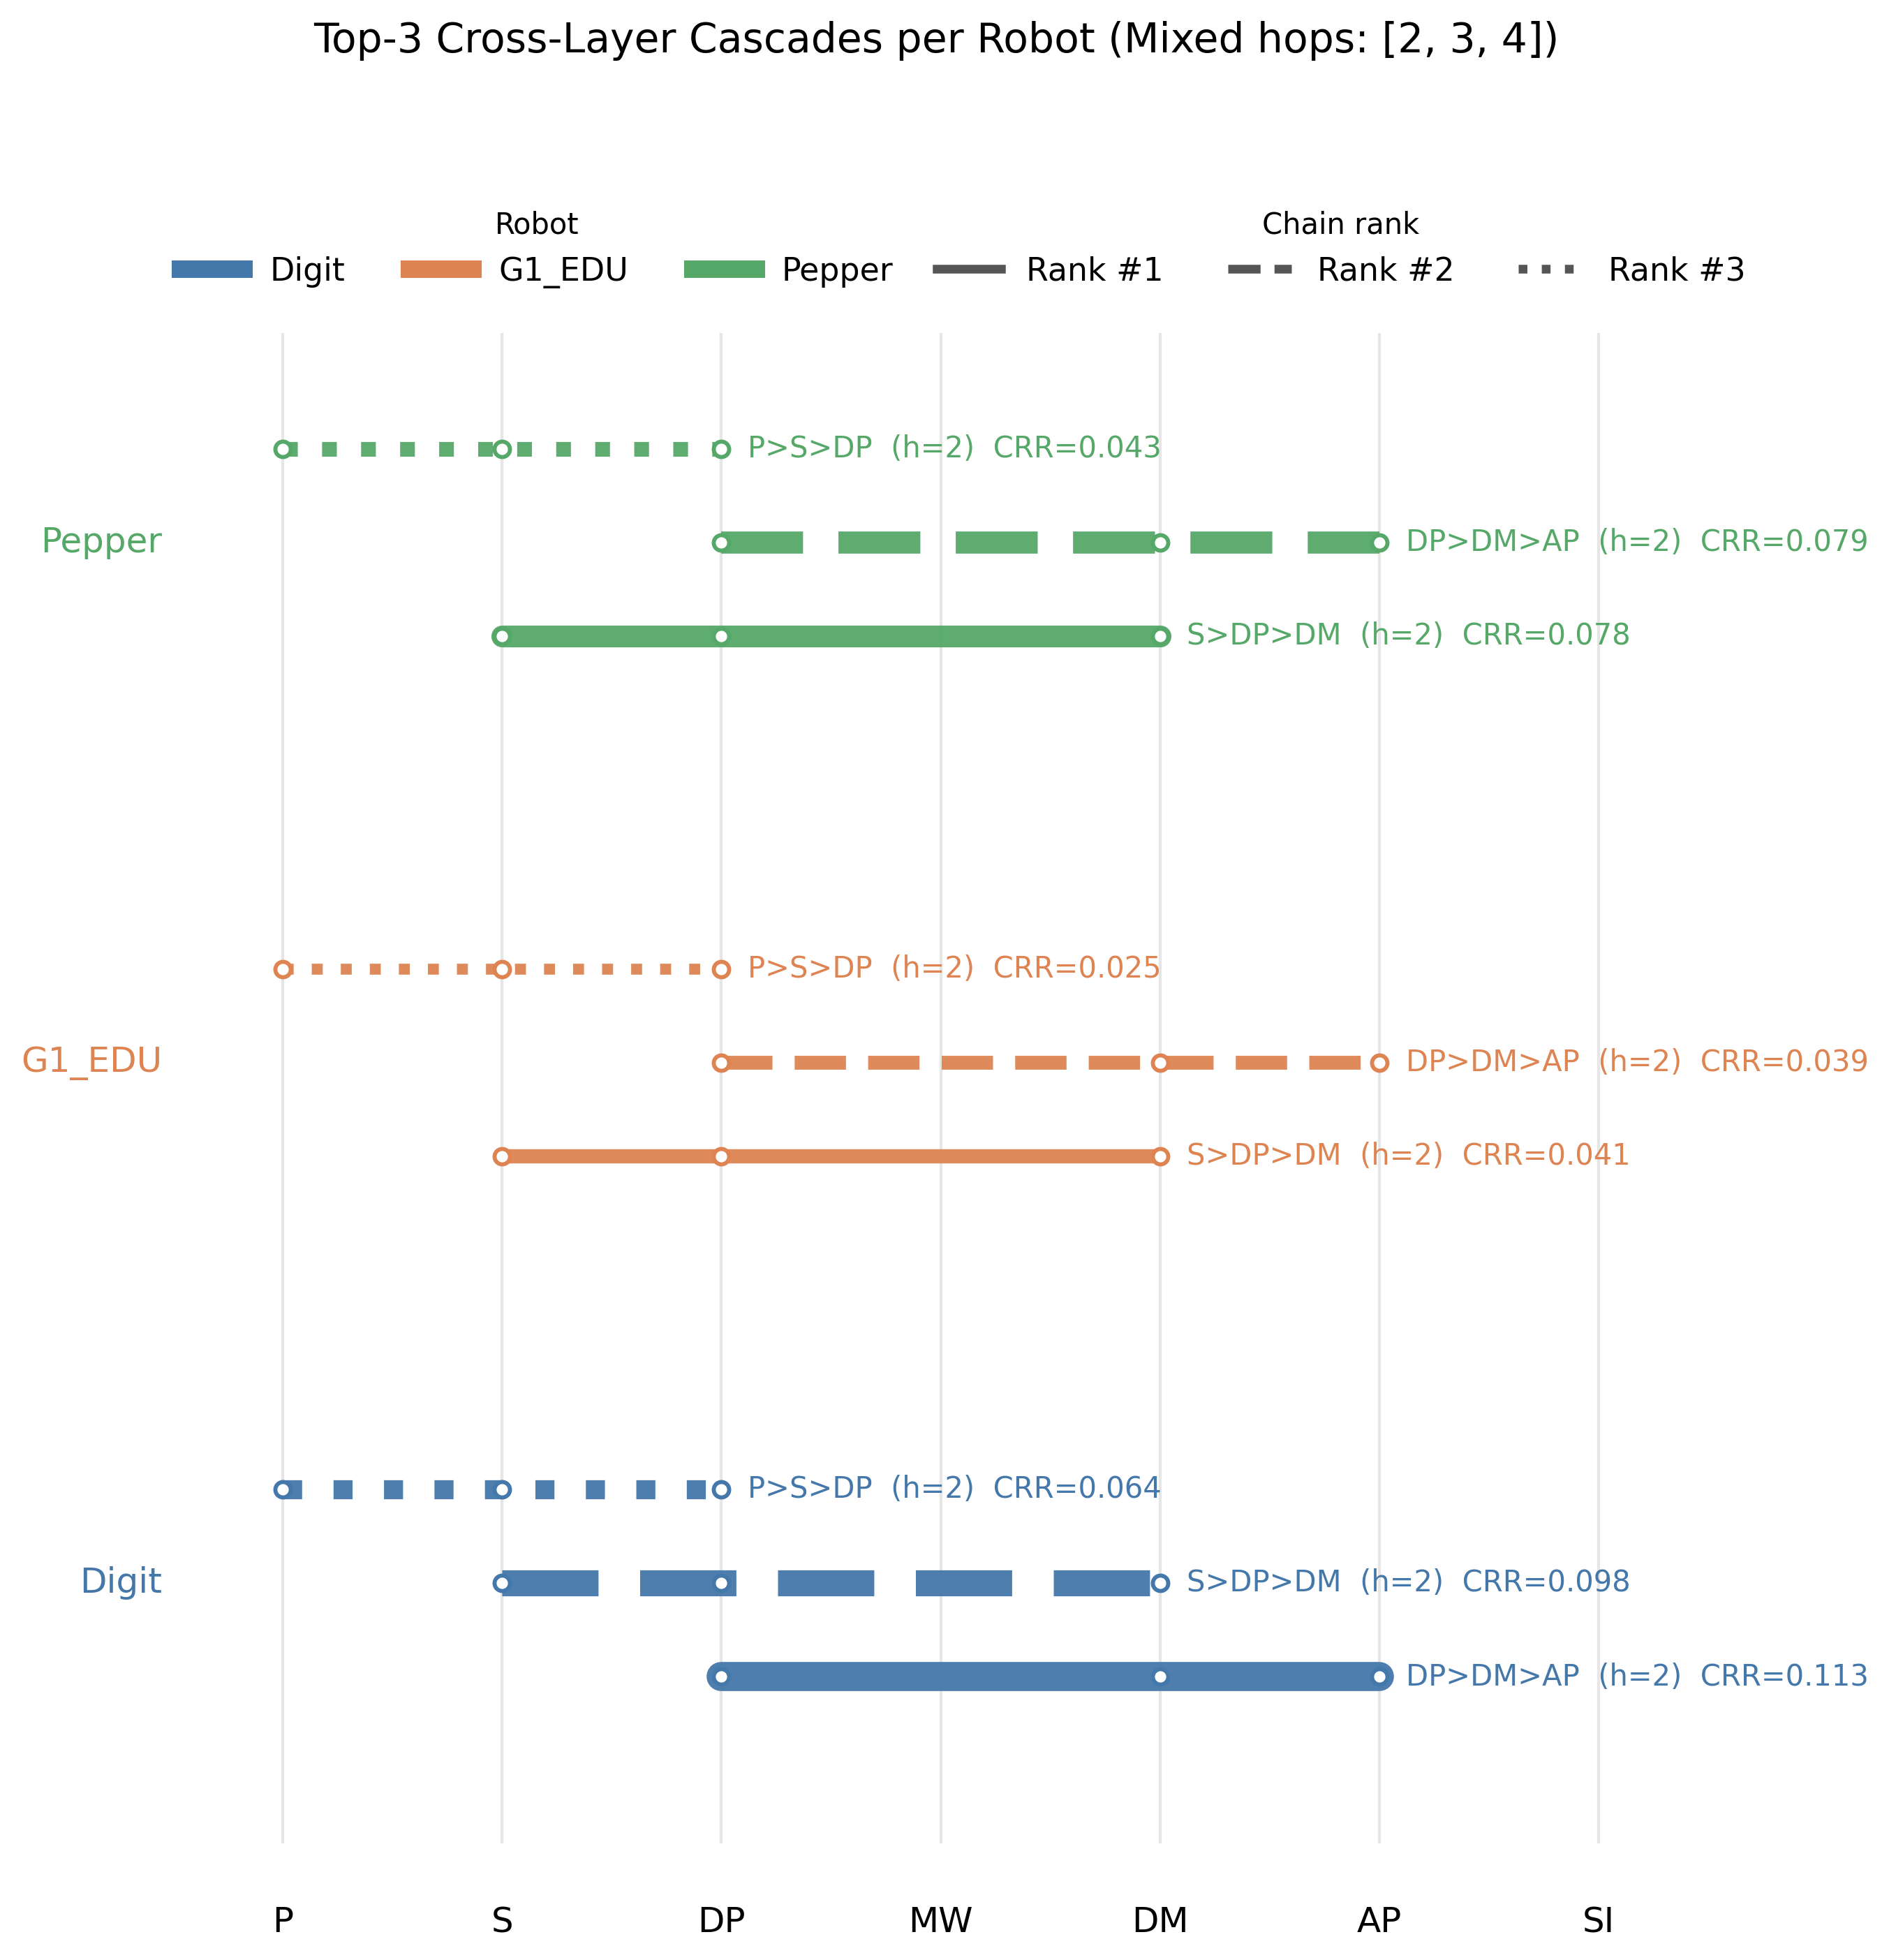

In [5]:
ok = run_python_script('cross_layer_pipeline_top3.py')
if ok:
    show_csv_anonymous(OUT_TOPK_DIR / 'topk_by_robot_mixed.csv', head=None, label='Top-K (mixed-hops)')
    show_images_anonymous([OUT_TOPK_DIR / 'fig_topk_mixed_square.png'], label_prefix='Top-K Figure')